In [2]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [10]:
num_steps = 200

In [9]:
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, ylim_max1])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2]) 
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([]) 

  plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

In [12]:
def leaky_integrate_and_fire(mem, x, w, beta, threshold=1):
  spk = (mem > threshold) # if membrane exceeds threshold, spk=1, else, 0
  mem = beta * mem + w*x - spk*threshold
  return spk, mem

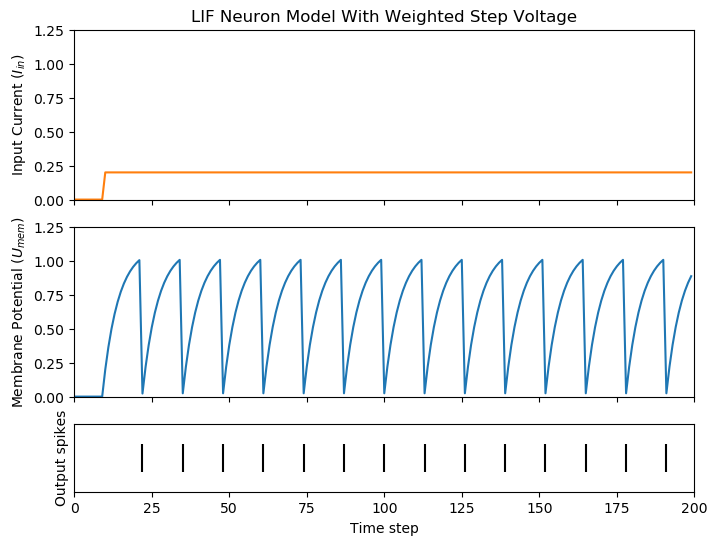

In [13]:

# initialize inputs/outputs + small step current input
x = torch.cat((torch.zeros(10), torch.ones(190)*0.5), 0)
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron parameters
w = 0.4
beta = 0.819

# neuron simulation
for step in range(num_steps):
  spk, mem = leaky_integrate_and_fire(mem, x[step], w=w, beta=beta)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(x*w, mem_rec, spk_rec, title="LIF Neuron Model With Weighted Step Voltage")



# all of the before simplified in snntorch

In [ ]:
lif1 = snn.Leaky(beta=0.8)

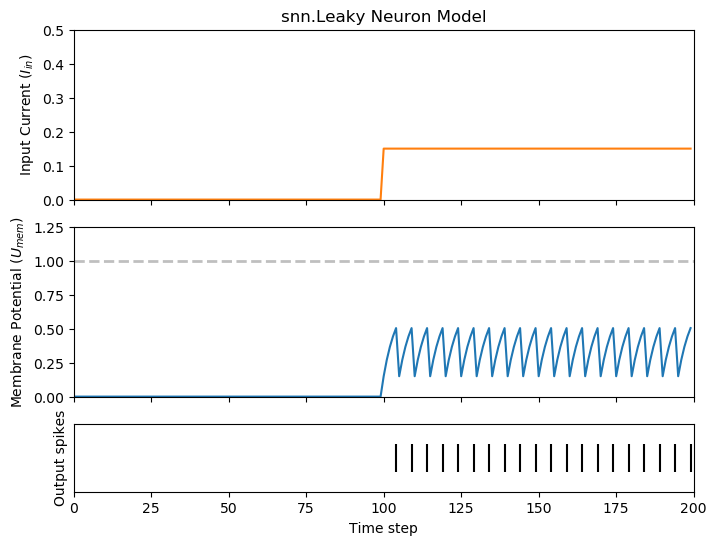

In [42]:
import random

# Small step current input
w=0.15
cur_in = torch.cat((torch.zeros(100), torch.ones(100)*w), 0)
mem = torch.zeros(1)
spk = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron simulation
for step in range(num_steps):
  spk, mem = lif1(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, ylim_max1=0.5,
                 title="snn.Leaky Neuron Model")

# Confirming behavior of Snn neuron with own experiment

In [84]:
import numpy as np
import pandas as pd

size = 10

negative = np.random.uniform(-2, -4, size=size)

positive = np.random.uniform(6, 10, size=size)

df1 = pd.DataFrame({
    'value': negative,
    'label': 0 
})

df2 = pd.DataFrame({
    'value': positive,
    'label': 1
})

df = pd.concat([df1, df2], ignore_index=True)

df = df.sample(frac=1, random_state=42)

train_data = df[:15]
test_data = df[16:]

In [88]:
w = -100

X_train = train_data["value"].to_numpy()
y_train = train_data["label"].to_numpy()

correctly_labeled = 0

while correctly_labeled != len(X_train):
    correctly_labeled = 0

    for index, x in enumerate(X_train):
        feature_val = w * x

        if y_train[index] == 1 and feature_val > 0:
            correctly_labeled += 1
        if y_train[index] == 1 and feature_val < 0:
            w = w + x
        if y_train[index] == 0 and feature_val < 0:
            correctly_labeled += 1
        if y_train[index] == 0 and feature_val > 0:
            w = w - x

    print(w, correctly_labeled)

-23.41222089492927 0
2.8229649495085534 10
2.8229649495085534 15


In [89]:
X_test = test_data["value"].to_numpy()
y_test = test_data["label"].to_numpy()

for index, x in enumerate(X_test):
    print(f"predicted: {x * w > 0} | label: {y_test[index]}")

predicted: False | label: 0
predicted: True | label: 1
predicted: True | label: 1
predicted: False | label: 0


# Deep Spiking neural network

In [3]:
# layer parameters
num_inputs = 784
num_hidden = 1000
num_outputs = 10
beta = 0.99

# initialize layers
fc1 = nn.Linear(num_inputs, num_hidden)
lif1 = snn.Leaky(beta=beta)
fc2 = nn.Linear(num_hidden, num_outputs)
lif2 = snn.Leaky(beta=beta)

In [14]:
# Initialize hidden states
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

# record outputs
mem2_rec = []
spk1_rec = []
spk2_rec = []

In [6]:
spk_in = spikegen.rate_conv(torch.rand((200, 784))).unsqueeze(1)

spk_in

tensor([[[0., 0., 0.,  ..., 1., 1., 0.]],

        [[0., 0., 1.,  ..., 1., 0., 0.]],

        [[1., 0., 1.,  ..., 0., 1., 1.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 0., 1.,  ..., 1., 0., 1.]],

        [[1., 0., 0.,  ..., 0., 0., 1.]]])

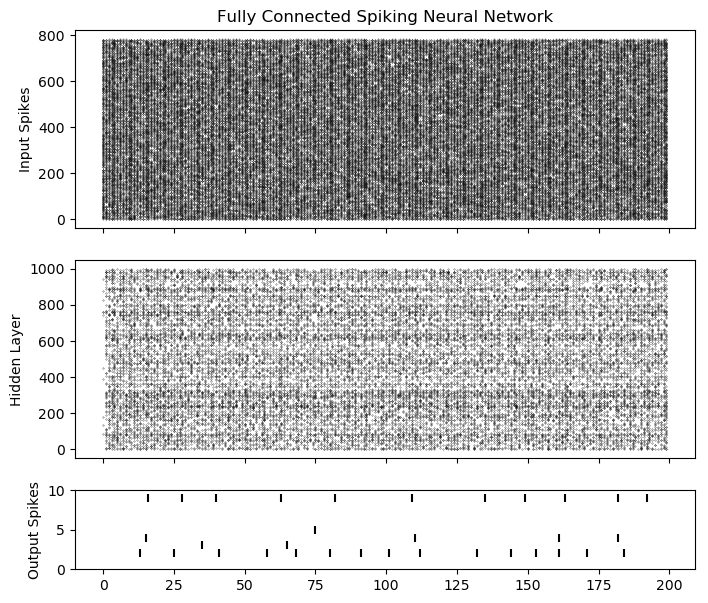

In [15]:
# network simulation
num_steps = 200

for step in range(num_steps):
    cur1 = fc1(spk_in[step]) # post-synaptic current <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem1) # mem[t+1] <--post-syn current + decayed membrane
    cur2 = fc2(spk1)
    spk2, mem2 = lif2(cur2, mem2)

    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)

# convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

plot_snn_spikes(spk_in, spk1_rec, spk2_rec, "Fully Connected Spiking Neural Network")

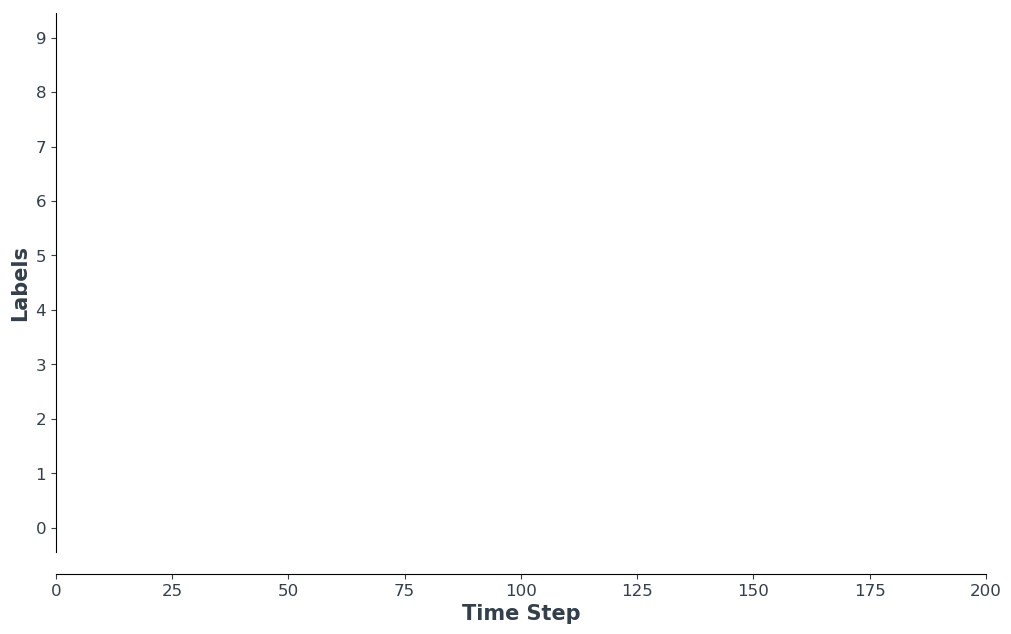

In [16]:
from IPython.display import HTML

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
spk2_rec = spk2_rec.squeeze(1).detach().cpu()

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk2_rec, fig, ax, labels=labels, animate=True)
HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")